## REINFORCE Algorithm

In [18]:
import gym
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

In [19]:
env = gym.make('CartPole-v1')

for _ in range(10):
    state, done = env.reset(), False
    while not done:
        action = env.action_space.sample()  # Random action
        state, _, done, _ = env.step(action)

        env.render()

env.close()

In [20]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
    
        self.input = nn.Linear(4,128)
        self.hidden1 = nn.ReLU()
        self.hidden2 = nn.Linear(128,2)
        self.output = nn.Softmax()


    def forward(self, x):
   
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
     
        return x

In [21]:
# Test code
_test_output = Policy()(torch.tensor([[1.0, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
np.testing.assert_almost_equal(_test_output.detach().numpy().sum(), 1, err_msg="Output is not a probability distribution.")
"ok"

C:\Users\Shaunak Kanikar\AppData\Local\Temp\ipykernel_14560\3966040788.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


'ok'

**Action Sampling**

In [22]:
def sample_action(probs):
    """Sample one action from the action distribution of this state."""
   
    action_distribution = torch.distributions.Categorical(probs)
    action = action_distribution.sample()
    log_prob = action_distribution.log_prob(action)
    
    return action, log_prob


In [23]:
# Test code
_test_action, _test_log_prob = sample_action(torch.tensor([1, 2, 3, 4]))
assert _test_action in [0, 1, 2, 3], f"Invalid action {_test_action}"
np.testing.assert_approx_equal(_test_log_prob, np.log((_test_action + 1) / 10))
"ok"

'ok'

**Return Estimation**

In [24]:
def estimate_return(rewards, gamma=0.99):
    """Estimate return based of observed rewards"""

    returns = [0]*(len(rewards))
    returns[-1] = rewards[-1]
    for i in range(len(rewards)-1):
        returns[-2-i] = rewards[-2-i] + gamma*returns[-1-i]
        
    # normalization
    mean = np.mean(returns)
    std = np.std(returns)
    returns = (returns - mean) / std

    return returns

In [25]:
# Test code
np.testing.assert_array_almost_equal(
    estimate_return(np.ones(10), gamma=0.99),
    [1.54572815, 1.21139962, 0.87369404, 0.53257729, 0.18801491, -0.16002789, -0.51158628, -0.86669576, -1.22539221, -1.58771185]
)
"ok"

'ok'

**Training Loop**

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Shaunak Kanikar\AppData\Local\Temp\ipykernel_14560\3966040788.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


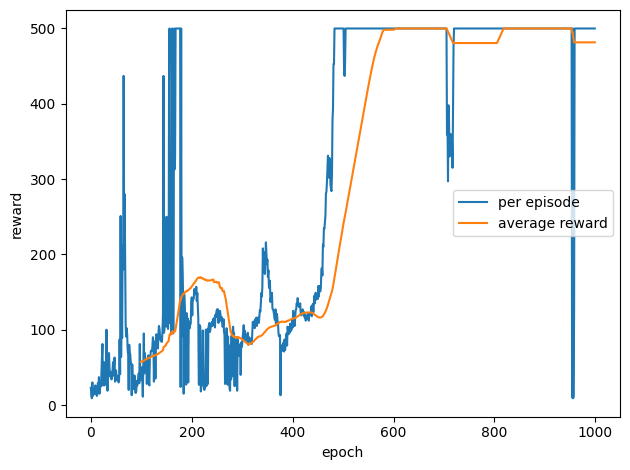

In [26]:
env = gym.make('CartPole-v1')
policy = Policy()

# Hyperparams
episodes = 1000
gamma = 0.99
learn_rate = 1e-2
optimizer = torch.optim.Adam(policy.parameters(), lr=learn_rate)

total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        # Run one episode
        log_probs = []
        rewards = []
        state, done = env.reset(), False
        while not done:
            # Take a step
            probs = policy.forward(torch.tensor(state))
            action, log_prob = sample_action(probs)

            state, reward, done, _ = env.step(action.numpy())

            # Bookkeeping
            log_probs.append(log_prob)
            rewards.append(reward)

        total_rewards.append(sum(rewards))


        estimated_return = estimate_return(rewards)
        policy_loss = 0
        for i in range(len(log_probs)):
            policy_loss -= log_probs[i] * estimated_return[i]

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")

# Save model
with open("solution/a2d.pt", "wb") as f:
    torch.save(policy, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/a2d.png")

In [27]:
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Shaunak Kanikar\AppData\Local\Temp\ipykernel_14560\3966040788.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


'ok (Average reward 500.00)'

In [28]:
# Take a look at the learned policy 
greedy = True

policy.eval()  # Switch to evaluation mode
state, done = env.reset(), False
while not done:
    probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
    if greedy:
        action = np.argmax(probs.detach().numpy())  # Chose optimal action
    else:
        action = sample_action(probs)[0]  # Sample from action distribution
    state, _, done, _ = env.step(action)
    env.render()

env.close()

C:\Users\Shaunak Kanikar\AppData\Local\Temp\ipykernel_14560\3966040788.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
